In [1]:
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionInpaintPipeline,DDIMScheduler
from torchvision.io import read_image, ImageReadMode
import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur
from pytorch_lightning import seed_everything
import os
from torchvision.utils import save_image
import cv2
from matplotlib import pyplot as plt

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 09:28:53.694431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 09:28:54.746030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dtype = torch.float16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
model_path = "../SD2-1-base" #"stable-diffusion-v1-5" "solarsync_v11"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    custom_pipeline="./pipelines/pipeline_inp.py",
    torch_dtype=dtype,  
)
pipe.to(device)
pipe.enable_attention_slicing()
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_inp.py:291: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very

In [3]:
#freeU
from utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2) #2.1
register_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)#2.1
#register_free_upblock2d(pipe, b1=1.5, b2=1.6, s1=0.9, s2=0.2) #1.5
#register_free_crossattn_upblock2d(pipe, b1=1.5, b2=1.6, s1=0.9, s2=0.2) #1.5

In [4]:

def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    if image.shape[1] != 3:
        image = image.expand(-1, 3, -1, -1)
    image = F.interpolate(image, (512, 512), mode="bicubic")
    #image = F.interpolate(image, (768, 768), mode="bicubic")
    image = image.to(dtype).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512), mode="bicubic")
    #mask = F.interpolate(mask, (768, 768), mode="bicubic")
    mask = gaussian_blur(mask, kernel_size=(7,7))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(dtype).to(device)
    return mask

seed = 123
seed_everything(seed)
generator=torch.Generator("cuda").manual_seed(seed)
sample = "an" 
out_dir = f"./workdir_inp/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
#out_dir = os.path.join(out_dir, "40")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"./examples/img/{sample}.png"
MASK_PATH = f"./examples/mask/{sample}_mask.png"
prompt = ""
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask_an = load_mask(MASK_PATH, device)


In [5]:
from AAS.AAS import AAS ,AAS_768
from AAS.AAS_utils import regiter_attention_editor_diffusers
strength = 0.8
num_inference_steps = 50
START_STEP = 0
END_STEP = int(strength*num_inference_steps)
LAYER = 7 #0~5down,6mid,7~15up
END_LAYER = 16

attentionstore = None
removelist=[6]
layer_idx=list(range(LAYER, END_LAYER))

# hijack the attention module
editor = AAS(attentionstore,START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an, ss_steps=9, ss_scale=0.3)
#editor = AAS_768(START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an, ss_steps=9,ss_scale=0.3)
regiter_attention_editor_diffusers(pipe, editor)

AAS at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
AAS at U-Net layers:  [7, 8, 9, 10, 11, 12, 13, 14, 15]
start AAS


In [6]:
image = pipe(
            prompt=prompt, 
            image=source_image, 
            mask_image=mask_an,
            num_inference_steps = num_inference_steps,
            strength=strength,
            generator=generator, 
            rm_guidance_scale=9,
            guidance_scale = 1,
            return_intermediates = False)

/usr/local/miniconda3/lib/python3.8/site-packages/diffusers/image_processor.py:542: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.96875,1.0]
  warnings.warn(
/hy-tmp/Attentive_Eraser/free_lunch_utils.py:39: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  x_freq = fft.fftn(x, dim=(-2, -1))
/usr/local/miniconda3/lib/python3.8/site-packages/diffusers/models/resnet.py:328: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.

In [7]:
def make_redder(img, mask, increase_factor=0.4):
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask_red = mask_an.squeeze(0)
img_redder = make_redder(img, mask_red)
#save_image(img_redder, os.path.join(out_dir, "redder.png"))

In [8]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageFilter
pil_mask = to_pil_image(mask_an.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask_an.device)
msak_f = 1-(1-mask_an)*(1-mask_blurred)

Syntheiszed images are saved in ./workdir_inp/an/sample_1


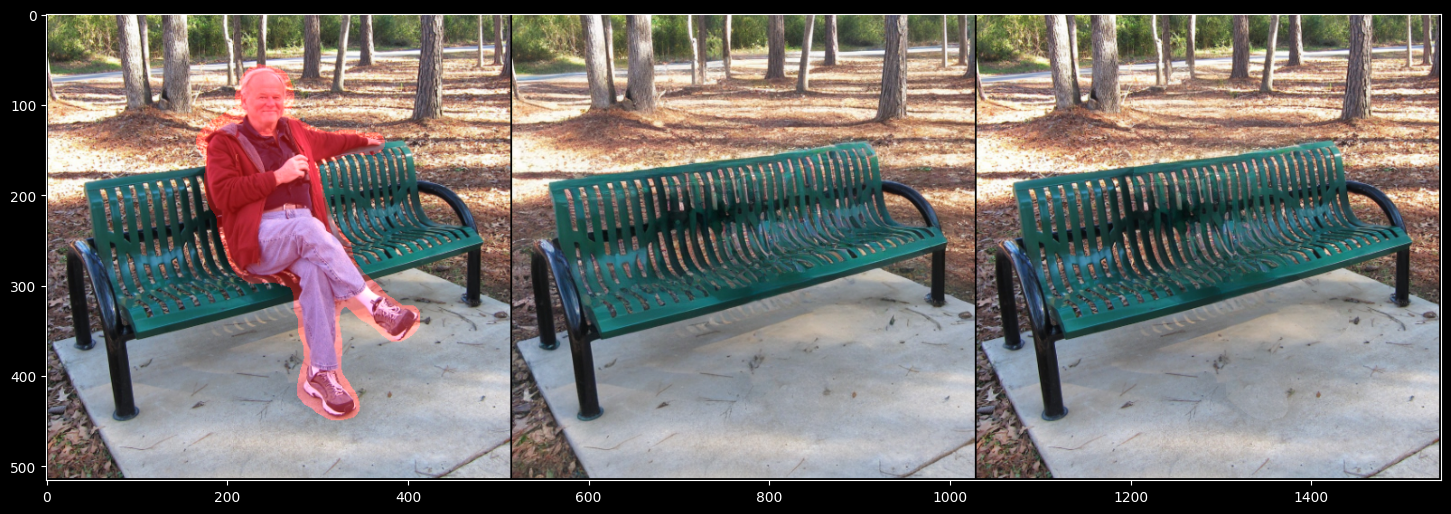

In [9]:
out_tile = msak_f * image[-1:] + (1 - msak_f) * (source_image* 0.5 + 0.5)
out_image = torch.concat([img_redder.unsqueeze(0),
                         image[-1:],
                         out_tile],
                         #image[:1]],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
#save_image(out_image[2], os.path.join(out_dir, f"compare_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)